# Parameter Inference and Calibration: Linking UER to GDP

View target demand as input to the model (instead of a stylized sinusoidal business cycle). 

I see two possible options:
1. GDP growth in line with Okun's Law specifically for unemployment - a 1% change in GDP = 0.03-0.05% change in UER
2. Growth in target demand


In [1]:
# Import packages
from abm_funs import *
from plot_funs import *
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
import tempfile
import pyabc
from scipy.stats import pearsonr, linregress
from pyabc.visualization import plot_kde_matrix, plot_kde_1d
import math as math
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
from IPython.display import display
from PIL import Image
from pstats import SortKey
import datetime
from collate_macro_vars import *
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
import csv
from dtaidistance import dtw
from functools import partial

rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"

import os
print(os.cpu_count()) 

calib = False
save = False

NEW Function import successful
8


In [2]:
#realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())

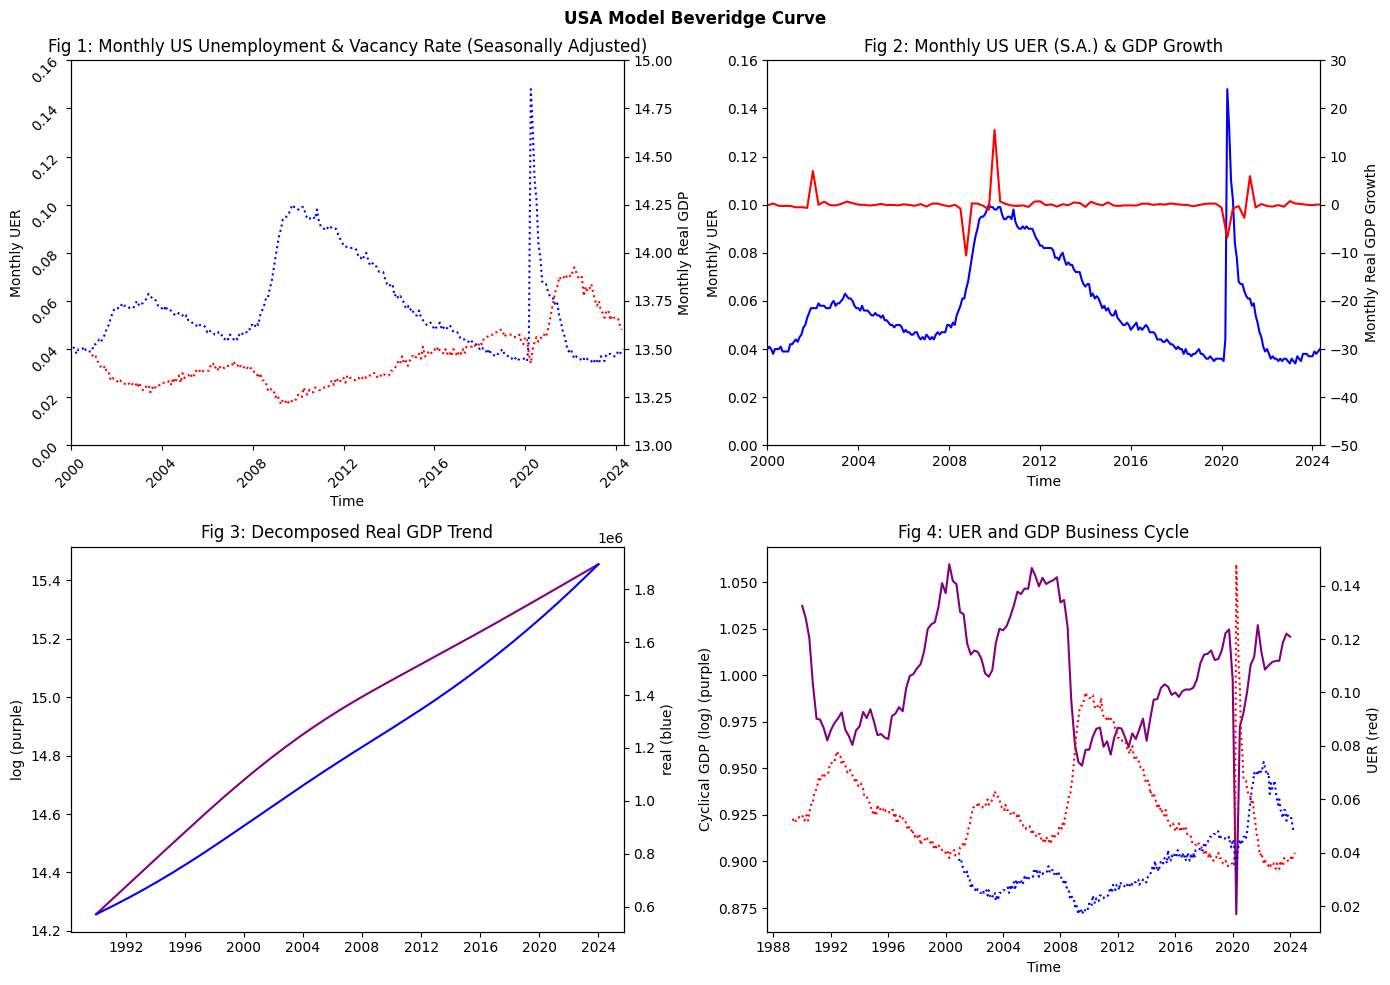

In [3]:

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

# Unpack the axes into variables for easier access
(ax1, ax2), (ax3, ax4) = axes


ax1.plot(macro_observations['DATE'], macro_observations['UER'], color = "blue", linestyle = "dotted")
ax1.plot(macro_observations['DATE'], macro_observations['VACRATE'], color = "red", linestyle = "dotted")
# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax1.set_title("Fig 1: Monthly US Unemployment & Vacancy Rate (Seasonally Adjusted)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Monthly UER")
ax1_twin = ax1.twinx()
ax1_twin.set_ylim([13, 15])
ax1.tick_params(rotation=45)
ax1.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])
ax1.set_ylim([0, 0.16])
ax1_twin.set_ylabel("Monthly Real GDP")

ax2.plot(macro_observations['DATE'], macro_observations['UER'], color = "blue")
ax2_twin = ax2.twinx()
ax2_twin.plot(gdp_growth['DATE'], gdp_growth['GDP_GROWTH'].pct_change(periods = 1), label = "Real GDP", color = "red")

# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_title("Fig 2: Monthly US UER (S.A.) & GDP Growth")
ax2.set_xlabel("Time")
ax2.set_ylabel("Monthly UER")
ax2.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])
ax2.set_ylim([0, 0.16])
ax2_twin.set_ylim([-50, 30])
ax2_twin.set_ylabel("Monthly Real GDP Growth")

ax3.plot(realgdp['DATE'], realgdp['log_Trend'], color = "purple")
ax3_twin = ax3.twinx()
ax3_twin.plot(realgdp['DATE'], realgdp['Trend'], color = "blue")
ax3.set_title("Fig 3: Decomposed Real GDP Trend")
ax3.set_ylabel("log (purple)")
ax3_twin.set_ylabel("real (blue)")

ax4.plot(realgdp['DATE'], realgdp['log_Cycle'], color = "purple")
ax4_twin = ax4.twinx()
ax4_twin.plot(macro_observations['DATE'], macro_observations['UER'], color = "red", linestyle = "dotted")
ax4_twin.plot(macro_observations['DATE'], macro_observations['VACRATE'], color = "blue", linestyle = "dotted")
ax4.set_title("Fig 4: Decomposed Real GDP Cycle")
ax4.set_ylabel("Cyclical GDP (log) (purple)")
#ax4.set_xlim([datetime.date(2000,1,1), datetime.date(2019,10,1)])

ax4_twin.set_ylabel("UER (red)")

# recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax4.set_title("Fig 4: UER and GDP Business Cycle")
ax4.set_xlabel("Time")
#ax4.set_xlim([datetime.date(2000,1,1), datetime.date(2024,5,1)])

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


#plt.savefig('../output/usa/beveridge_behav_0_1_all.jpg', dpi = 300)
plt.show()
plt.close()


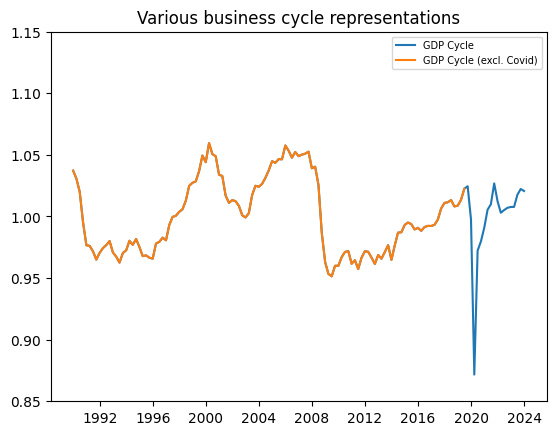

In [4]:
t = np.arange(0,len(realgdp['DATE']),1)
#bus_cycle = bus_cycle_demand(0.5, t, 1, 30)

#plt.plot(realgdp['DATE'], bus_cycle, label = "Stylised Sinusoidal Business Cycle")
plt.plot(realgdp['DATE'], realgdp['log_Cycle'], label = "GDP Cycle")
plt.plot(realgdp_no_covid['DATE'], realgdp_no_covid['log_Cycle'], label = "GDP Cycle (excl. Covid)")
#plt.plot(np.arange(0,78,1), gdp_dat, label = "Calib Period" )
plt.legend(fontsize=7)
plt.ylim([0.85,1.15])
plt.title("Various business cycle representations")

plt.show()

# Save to CSV
realgdp_no_covid.to_csv('detrended_gdp_nocovid.csv', index=False)
# Save to CSV
realgdp.to_csv('detrended_gdp.csv', index=False)

In [5]:

# def smooth_transition(start_value, end_value, num_points, noise_std=0.01):
#     """
#     Creates a smooth transition between a single start value and a single end value 
#     over num_points using linear interpolation, with optional noise.

#     Parameters:
#         start_value (float): The starting value for interpolation.
#         end_value (float): The ending value for interpolation.
#         num_points (int): The number of points in the transition.
#         noise_std (float): Standard deviation of random noise to add.

#     Returns:
#         np.ndarray: Interpolated values with added noise.
#     """
#     weights = np.linspace(0, 1, num_points)
#     transition_values = start_value * (1 - weights) + end_value * weights

#     # Add small noise for realism
#     transition_values += np.random.normal(0, noise_std, num_points)

#     return transition_values

# def extend_time_series(df, date_col='DATE', value_col='log_Cycle', num_extra=150, transition_period=30, noise_factor=0.1):
#     """
#     Extends a time series by adding synthetic values before and after, with a smooth transition.
    
#     Parameters:
#         df (pd.DataFrame): The original time series with a date and value column.
#         date_col (str): Name of the date column.
#         value_col (str): Name of the value column.
#         num_extra (int): Total number of synthetic observations before and after.
#         transition_period (int): Number of points where the transition to real data happens.
#         noise_factor (float): Noise intensity (as a fraction of standard deviation).
        
#     Returns:
#         pd.DataFrame: The extended DataFrame with additional time observations.
#     """
    
#     # Ensure DataFrame is sorted by date
#     df = df.sort_values(by=date_col).reset_index(drop=True)
    
#     # Compute mean and noise level
#     mean_value = df[value_col].mean()
#     noise_std = df[value_col].std() * noise_factor
    
#     # Generate synthetic values fluctuating around the mean
#     before_values = mean_value + np.random.normal(0, noise_std, num_extra)
#     after_values = mean_value + np.random.normal(0, noise_std, num_extra)
    
#     # Create a smooth transition for the last 10 points before real data

#     transition_before = smooth_transition(before_values[-transition_period], df[value_col].iloc[0], transition_period, noise_std = noise_std)
#     transition_after = smooth_transition(df[value_col].iloc[-1], after_values[transition_period], transition_period, noise_std = noise_std)
    
#     # Replace the last 10 synthetic values with the smooth transition
#     before_values[-transition_period:] = transition_before
#     after_values[:transition_period] = transition_after

#     # Generate new dates
#     date_range = pd.date_range(start=df[date_col].min(), periods=len(df), freq=pd.infer_freq(df[date_col]) or 'D')
#     df[date_col] = date_range  

#     before_dates = pd.date_range(end=df[date_col].min(), periods=num_extra + 1, freq=date_range.freq)[:-1]
#     after_dates = pd.date_range(start=df[date_col].max(), periods=num_extra + 1, freq=date_range.freq)[1:]

#     # Create DataFrames for before and after periods
#     before_df = pd.DataFrame({date_col: before_dates, value_col: before_values})
#     after_df = pd.DataFrame({date_col: after_dates, value_col: after_values})

#     # Concatenate all parts
#     extended_df = pd.concat([before_df, df, after_df], ignore_index=True)

#     return extended_df, before_df, after_df  # Return all parts separately for plotting

# # ---- RUN FUNCTION & PLOT RESULTS ----
# extended_gdp_df, before_gdp_df, after_gdp_df = extend_time_series(gdp_dat_pd)

# # Mean-centered noise
# mean_gdp_cycle = pd.DataFrame({'DATE': gdp_dat_pd['DATE'], 'VALUE': gdp_dat_pd['log_Cycle'].mean() + np.random.normal(0, gdp_dat_pd['log_Cycle'].std()*0.05, len(gdp_dat_pd))})

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

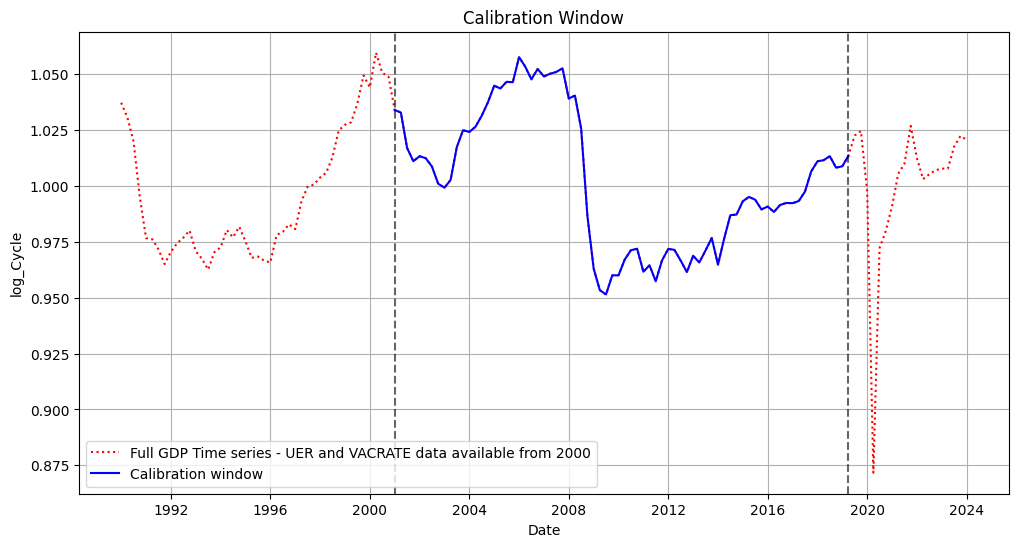

In [6]:
# Different calibration windoes
# Full time series: "2024-5-1"
# calib_date = ["2004-12-01", "2019-05-01"]
calib_date = ["2000-12-01", "2019-05-01"]
# calib_date = ["2000-12-01", "2024-05-01"]
gdp_dat_pd = realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]
#gdp_dat = np.array(gdp_dat_pd['scaled_log_Cycle'])# *0.06

# PLOTTING
plt.figure(figsize=(12, 6))

# Plot original data
sns.lineplot(data = realgdp, x = 'DATE', y = 'log_Cycle', color = "red", label = "Full GDP Time series - UER and VACRATE data available from 2000", linestyle = "dotted")
sns.lineplot(data=gdp_dat_pd, x='DATE', y='log_Cycle', color='blue', label='Calibration window')

# Plot synthetic data fluctuating around mean
#sns.lineplot(data=before_gdp_df, x='DATE', y='scaled_log_Cycle', color='red', linestyle='dashed', label='Before (Synthetic)')
#sns.lineplot(data=after_gdp_df, x='DATE', y='scaled_log_Cycle', color='red', linestyle='dashed', label='After (Synthetic)')
#sns.lineplot(data=extended_gdp_df, x='DATE', y='log_Cycle', color='red', linestyle='dashed', label='Full TS with Synthetic Data Extension')
#sns.lineplot(data = mean_gdp_cycle, x = 'DATE', y = 'VALUE', color = "purple", label = "Synthetic Stationary Data Around Mean")

# Mark original data boundaries
plt.axvline(x=gdp_dat_pd['DATE'].min(), color='black', linestyle='--', alpha=0.6)
plt.axvline(x=gdp_dat_pd['DATE'].max(), color='black', linestyle='--', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('log_Cycle')
plt.title('Calibration Window')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################

# Incorporate calibrated parameters
param_base_df = pd.read_csv("output/output_26_03/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_base_df = param_base_df.sort_values(by='Timestamp', ascending=False)
# Keep only the latest version of each parameter by removing duplicates
param_base_df = param_base_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')

#gdp_dat = np.array(mean_gdp_cycle['VALUE'])
gdp_dat = np.array(gdp_dat_pd['log_Cycle'])

#for calib_cond in calib_conditions:
# Filter parameters for the current calibration condition
# condition_params = param_df[param_df['Calib_condition'] == calib_cond]

A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
print(vac_rate_base)
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)

params = {'mod_data': mod_data, # mod_data: occupation-level input data (ie. employment/uneployment levels, wages, gender ratio, etc.).
     'net_temp': net_temp, # net_temp: occupational network
     'vacs': vacs, # list of available vacancies in the economy
     'behav_spec': False, # whether or not to enable behavioural element or not (boolean value)
     'time_steps': len(gdp_dat), # number of time steps to iterate the model - for now always exclude ~50 time steps for the model to reach a steady-state
     # 'd_u': del_u, # del_u: spontaneous separation rate
     # 'd_v': del_v, # del_v: spontaneous vacancy rate
     # 'gamma_u': gamma_u, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     # 'gamma_v': gamma_v, # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     'delay': 0,
     'gdp_data': gdp_dat,
     'simple_res': True} #

params.update(
    param_base_df[param_base_df['Behav_Mode'] == False].set_index('Parameter')['Value'].to_dict()
)
bparams = deepcopy(params)
bparams.update(
    param_base_df[param_base_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
)
bparams['behav_spec'] = True


0.029513888888888888


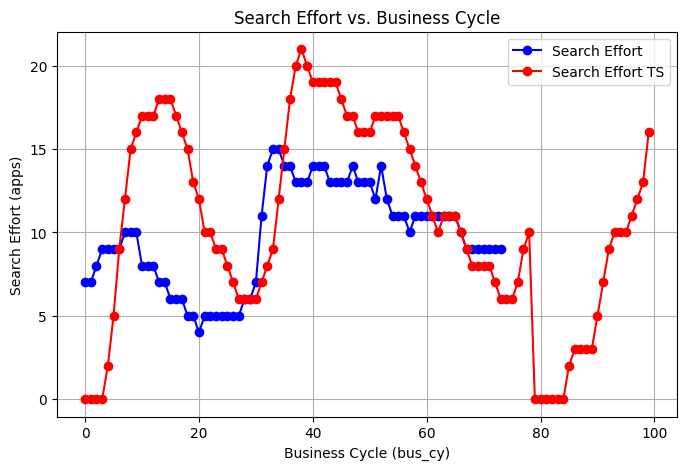

In [8]:
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()
#realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b) for b in gdp_dat]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
####################
# Model Run ########
####################
def run_single_local(mod_data = mod_data, 
               net_temp = net_temp, 
               vacs = vacs, 
               behav_spec = params['behav_spec'], 
               time_steps = len(gdp_dat), # set equal to length of gdp_data
               d_u = params['d_u'], 
               d_v = params['d_v'],
               gamma_u = params['gamma_u'],
               gamma_v = params['gamma_v'],
               delay = 0,
               gdp_data = gdp_dat,
               simple_res = True,
               search_eff_ts = search_effort_np):
    
    """ Runs the model once
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    # Initialise deepcopy occupational mobility network
    print(behav_spec)
    record = [np.sum(np.concatenate((np.zeros((464, 1)), 
                                    mod_data['employment'].to_numpy(), 
                                    mod_data['unemployment'].to_numpy(), 
                                    mod_data['employment'].to_numpy() + mod_data['unemployment'].to_numpy(),
                                    mod_data['vacancies'].to_numpy(), 
                                    np.zeros((464, 1)),
                                    mod_data['demand_target'].to_numpy(),
                                    mod_data['demand_target'].to_numpy(),
                                    np.zeros((464, 1)),
                                    np.zeros((464, 1))), axis = 1), 
                                    axis = 0)]
    
    #print(parameter['vacs'])
    vacs_temp = deepcopy(vacs)
    net = deepcopy(net_temp)
    for t in range(time_steps):
        if t == 1:
            print(behav_spec)
        curr_bus_cy = gdp_data[t]
        search_eff_curr = search_eff_ts[t]
        # Ensure number of workers in economy has not changed
        #tic = time.process_time()
        emp_seekers = 0
        unemp_seekers = 0
        for occ in net:
            ### APPLICATIONS
            # Questions to verify:
            # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # - CAN be rejected and apply in the same time step - no protected attribute
            # isolate list of vacancies in economy that are relevant to the occupation
            # - avoids selecting in each search_and_apply application
            r_vacs = [vac for vac in vacs_temp if occ.list_of_neigh_bool[vac.occupation_id]]          
    
            for u in occ.list_of_unemployed:
                unemp_seekers += 1
                # this one if only using simple scaling factor for the search effort
                u.search_and_apply(net, r_vacs, behav_spec, curr_bus_cy)
                # use the following if we wish to incorporate the entire TS of search effort
                #u.search_and_apply(net, r_vacs, behav_spec, search_eff_curr)
            
            # For both models, a mean of 40% of employed workers are searching for new jobs
            # This fluctuates with the business cycle in the behavioural model in line with gdp
            if behav_spec:
                search_scaling = curr_bus_cy*0.1
            # Static mean in the non-behavioural model
            else:
                search_scaling = 0.1
            for e in random.sample(occ.list_of_employed, int(search_scaling*len(occ.list_of_employed))):
                emp_seekers += 1
                e.emp_search_and_apply(net, r_vacs)

            ### SEPARATIONS
            try:
                occ.separate_workers(d_u, gamma_u, curr_bus_cy)
            except Exception as e:
                return np.inf

        ### HIRING
        # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
        # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
        # ....might be better to do this using an unordered set?
        for v_open in sorted(vacs_temp,key=lambda _: random.random()):
            # Removes any applicants that have already been hired in another vacancy
            v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
            v_open.time_open += 1
            if len(v_open.applicants) > 0:
                v_open.hire(net)
                v_open.filled = True
                #vacs.remove(v_open)
                assert(len(v_open.applicants) == 0)
            else:
                pass

        vacs_temp = [v for v in vacs_temp if not(v.filled) and v.time_open <= 1] 

        # Reset counters for record in time t
        empl = 0 
        unemp = 0
        n_ltue = 0
        curr_demand = 0
        t_demand = 0

        ### OPEN VACANCIES
        # Update vacancies after all shifts have taken place
        # Could consider making this a function of the class itself?
        for occ in net:
            # Update time_unemployed and long-term unemployed status of unemployed workers
            # Remove protected "hired" attribute of employed workers
            occ.update_workers()
            # Assert that all unemployed people have spent 1 or more time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_unemployed]) == 0)
            # Assert that all employed people have spent 0 time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_employed]) == len(occ.list_of_employed))
            emp = len(occ.list_of_employed)
            occ.current_demand = (len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp)
            #occ.current_demand = bus_cycle_demand(len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp, t, bus_amp, bus_cycle_len)
            vac_prob = d_v + ((gamma_v * max(0, occ.target_demand*(curr_bus_cy) - occ.current_demand)) / (emp + 1))
            #vac_prob = d_v + ((1 - d_v) * (gamma_v * max(0, occ.target_demand - occ.current_demand))) / (emp + 1)
            vacs_create = emp*int(vac_prob) + int(np.random.binomial(emp, vac_prob%1))
            for v in range(vacs_create):
                vacs_temp.append(vac(occ.occupation_id, [], occ.wage, False, 0))

            empl += len(occ.list_of_employed) 
            unemp += len(occ.list_of_unemployed)
            n_ltue += sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed)
            curr_demand += occ.current_demand
            t_demand += occ.target_demand*curr_bus_cy

        ### UPDATE INDICATOR RECORD
        record = np.append(record, 
                               np.array([[t+1, empl, unemp, empl + unemp, len(vacs_temp), n_ltue, curr_demand, t_demand, emp_seekers, unemp_seekers]]), 
                               axis = 0)


    # clean_record = pd.DataFrame(record[delay:])
    # clean_record.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
    # clean_record['UER'] = clean_record['Unemployment']/clean_record['Workers']
    # clean_record['VACRATE'] = clean_record['Vacancies']/clean_record['Target_Demand']
    #data = clean_record[['Time Step', 'UER', 'VACRATE']]
    data = {'UER': record[delay:,2]/record[delay:,3], 
            'VACRATE': record[delay:,4]/record[delay:,7]}

    #ltuer = (clean_record['LT Unemployed Persons']/clean_record['Workers']).mean(axis = 0)
    #vac_rate = (clean_record['Vacancies']/clean_record['Target_Demand']).mean(axis = 0)
    if simple_res:
        return data
    else:
        return record[1:,:], net, data

#########################################
# Wrapper for pyabc ########
#########################################
def pyabc_run_single(parameter):     
    res = run_single_local(**parameter)
    return res 


In [10]:
params.update({'simple_res': False})
test_nonbehav = run_single_local(**params)
sim_record = pd.DataFrame(test_nonbehav[0])
sim_data = pd.DataFrame(test_nonbehav[2])
sim_data['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data))

bparams.update({'simple_res': False})
test_behav = run_single_local(**bparams)
sim_record_t = pd.DataFrame(test_behav[0])
sim_data_t = pd.DataFrame(test_behav[2])
sim_data_t['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data_t))

sim_record.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand', 'Employed Seekers', 'Unemployed Seekers']
sim_record_t.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand', 'Employed Seekers', 'Unemployed Seekers']


False
False
True
True


0
1175
0
1307


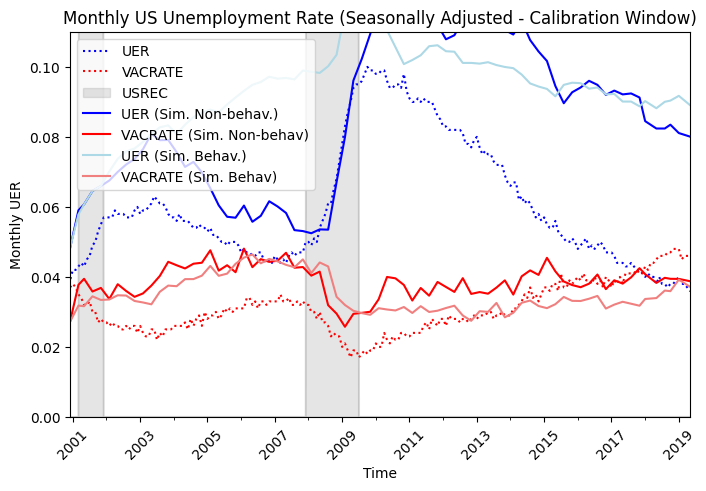

In [11]:
count = sum(len([worker for worker in occ.list_of_unemployed if worker.time_unemployed == 0]) for occ in test_nonbehav[1])
count2 = sum(len([worker for worker in occ.list_of_unemployed]) for occ in test_nonbehav[1])
print(count)
print(count2)

count = sum(len([worker for worker in occ.list_of_unemployed if worker.time_unemployed == 0]) for occ in test_behav[1])
count2 = sum(len([worker for worker in occ.list_of_unemployed]) for occ in test_behav[1])
print(count)
print(count2)

# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
sim_data_t.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "lightblue", label = "UER (Sim. Behav.)")
sim_data_t.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav)")
plt.plot(np.arange(0, len(gdp_dat), 1), gdp_dat)
#sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Behav.)")
#sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav.)")

plt.xlim(calib_date[0], calib_date[1])
plt.ylim(0, 0.11)

# Add title and axis labels   
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted - Calibration Window)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()


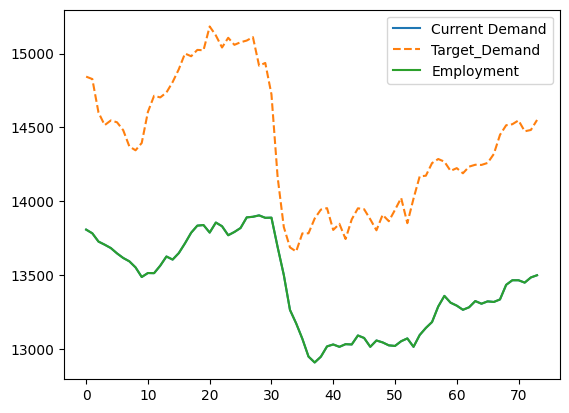

In [12]:
plt.plot(sim_record['Current Demand'], label = "Current Demand")
plt.plot(sim_record['Target_Demand'], label = "Target_Demand", linestyle = "dashed")
#plt.plot(sim_record['Vacancies'], label = "Vacs")
plt.plot(sim_record['Employment'], label = "Employment")#
#plt.plot(sim_record['Unemployment'], label = "Unemployment")
plt.legend()

In [13]:
def harmonise_length(x, y):
    """
    GDP data used to calibrate has lower periodicity than the UER and VACRATE used for calibration. The following linearly interpolates the simulated output to match the frequency of the UER and Vacancy Rate data
    Harmonises the length of the time series to compare to each other. 
        
    Args:
        x (dict): Simulated data with keys "UER" and "VACRATE".
        y (dict): Real-world data with keys "UER" and "VACRATE".
    
    Returns:
        expanded_format: x expanded via linear interpolation - now of same length as y (observed time series of UER and vacancy rate)
    """
    expanded_format = pd.DataFrame({
        col: np.interp(
            np.linspace(0, len(x[col]) - 1, len(y[col])),
            np.linspace(0, len(x[col]) - 1, len(x[col])),
            x[col]
            )
            for col in x.keys()
            })
    return expanded_format

def distance_weighted(x, y): #weight_shape=0, weight_mean=1):
    x_ = harmonise_length(x, y)
    
    # Normalized SSE using variance
    uer_sse = np.sum((x_["UER"] - y["UER"])**2) / np.var(y["UER"])
    vacrate_sse = np.sum((x_["VACRATE"] - y["VACRATE"])**2) / np.var(y["VACRATE"])

    # # DTW for shape matching
    # dtw_vacrate = dtw.distance(x_["VACRATE"], y["VACRATE"])/np.std(y['VACRATE'])
    # dtw_uer = dtw.distance(x_["UER"], y["UER"])/np.std(y['UER'])

    #trend_penalty_uer = trend_penalty(x_["UER"], y["UER"])
    #trend_penalty_vac = trend_penalty(x_["VACRATE"], y["VACRATE"])

    # Weighted combination
    dist = (np.sqrt(uer_sse) + np.sqrt(vacrate_sse))

    #dist = weight_mean * (np.sqrt(uer_sse) + np.sqrt(vacrate_sse)) + weight_shape * (dtw_vacrate + dtw_uer) # + 0.4 * (trend_penalty_uer + trend_penalty_vac)
    return dist

# if not save:

#     calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs = 100)
#     abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size = 100, sampler = calib_sampler)

#     db_path = os.path.join(tempfile.gettempdir(), "test.db")

#     # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
#     observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
#     #observation = pd.DataFrame({'DATE': observation['DATE'], 'UER': observation['UER'].mean() + np.random.normal(0, observation['UER'].std()*0.05, len(observation)), 'VACRATE': observation['VACRATE'].mean() + np.random.normal(0, observation['VACRATE'].std()*0.05, len(observation))})

#     data = {'UER': np.array(observation['UER']),
#             'VACRATE': np.array(observation['VACRATE'])}

#     abc.new("sqlite:///" + db_path, data)

#     history = abc.run(minimum_epsilon=0.1, max_nr_populations=15)


In [14]:
# if not save:
#     df, w = history.get_distribution(t=history.max_t)

#     gt = {"d_u": np.sum(df['d_u']*w), "d_v": np.sum(df['d_v']*w), "gamma_u": np.sum(df['gamma_u']*w), "gamma_v": np.sum(df['gamma_v']*w)}

#     plot_kde_matrix(
#         df,
#         w,
#         limits={"d_u": (0.00001, 0.1), "d_v": (0.00011, 0.1), "gamma_u": (0.00001, 1), "gamma_v": (0.00001, 1)},
#         refval=gt,
#         refval_color='k',
#     )
#     # Not sure if the value to be extracted is the weighted mean of the outcome or simply the mean?
#     sns.jointplot(x = "d_u", y = "d_v", kind = "kde", data = df, weights = w, cmap = "viridis_r")
#     plt.axvline(x = df['d_u'].mean(axis = 0))
#     plt.axvline(x = np.sum(df['d_u']*w), color = 'red')
#     plt.axhline(y = df['d_v'].mean(axis = 0))
#     plt.axhline(y = np.sum(df['d_v']*w), color = 'red')
#     plt.title("KDE Plot")
#     plt.plot()

#     sns.jointplot(x = "gamma_u", y = "gamma_v", kind = "kde", data = df, weights = w, cmap = "viridis_r")
#     plt.axvline(x = df['gamma_u'].mean(axis = 0))
#     plt.axvline(x = np.sum(df['gamma_u']*w), color = 'red')
#     plt.axhline(y = df['gamma_v'].mean(axis = 0))
#     plt.axhline(y = np.sum(df['gamma_v']*w), color = 'red')
#     plt.title("KDE Plot")
#     plt.plot()


#     # The following graphs shows simulation results using parameter combinations sampled from the original prior (worst fit), final posterior (better fit), and accepted parameter combinations from the final posterior distribution which gives the best fit. It seems the prior set is likelly too restrictive as the algorithm has a difficult time arriving at an adequate vacancy rate! To be explored further...The left (right) column shows the results for the UER (Vacancy rate) and the black line in each plot demonstrates the observed data from BLS and JOLTS.

#     ####################################################################################
#     #### Prior and Posterior Distribution outputs versus Observed UER and Vacancy Rates
#     fig, axes = plt.subplots(3, 2, sharex=True)
#     fig.set_size_inches(8, 12)
#     n = 5  # Number of samples to plot from each category
#     #Plot samples from the prior
#     alpha = 0.5
#     params.update({'simple_res': True})
#     for _ in range(n):
#         params.update(prior.rvs())
#         prior_sample = harmonise_length(run_single_local(**params), observation)
#         #print(prior_sample)
#         axes[0,0].plot(prior_sample["UER"], color="red", alpha=alpha)
#         axes[0,1].plot(prior_sample["VACRATE"], color="red", alpha=alpha)

#     # Fit a posterior KDE and plot samples form it
#     posterior = MultivariateNormalTransition()
#     posterior.fit(*history.get_distribution(m=0))

#     for _ in range(n):
#         params.update(posterior.rvs())
#         posterior_sample = harmonise_length(run_single_local(**params), observation)
#         axes[1,0].plot(posterior_sample["UER"], color="blue", alpha=alpha)
#         axes[1,1].plot(posterior_sample["VACRATE"], color="blue", alpha=alpha)

#     # Plot the stored summary statistics
#     sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
#     for stored in sum_stats[1][:n]:
#         stored_ = harmonise_length(stored, observation)
#         axes[2,0].plot(stored_["UER"], color="green", alpha=alpha)
#         axes[2,1].plot(stored_["VACRATE"], color="green", alpha=alpha)

#     # Plot the observed UER from BLS
#     for ax in axes[:,0]:
#         observation.plot(y="UER", ax=ax, color="black", linewidth=1.5)
#         ax.legend().set_visible(False)
#         ax.set_ylabel("UER")
        
#     # Plot the observed VACRATE from JOLTS
#     for ax in axes[:,1]:
#         observation.plot(y="VACRATE", ax=ax, color="black", linewidth=1.5)
#         ax.legend().set_visible(False)
#         ax.set_ylabel("VACANCY RATE")
#         ax.yaxis.set_label_position("right")

#     fig.suptitle("Simulation Results using Parameters from Prior (sampled), Posterior (sampled), and Posterior (sampled & accepted)")
#     # Add a legend with pseudo artists to first plot
#     fig.legend(
#         [
#             plt.plot([0], color="red")[0],
#             plt.plot([0], color="blue")[0],
#             plt.plot([0], color="green")[0],
#             plt.plot([0], color="black")[0],
#         ],
#         ["Prior", "Posterior", "Stored, accepted", "Observation"],
#         bbox_to_anchor=(0.5, 0.9),
#         loc="lower center",
#         ncol=4,
#     )

#     plt.plot()

#     ## Testing Selected final_params
#     #Below I pull the weighted mean of the posterior. Not sure if this is the correct way to pull the triangulated parameter estimate...? 
#     #Indeed, the model run with these final_params does not look good and both look lower than represented in the heat/contour maps above. The model results with these final_params look bad both with respect to replicating a Beveridge curve as well as we did earlier with hand-selected estimates (and you'll see by the warnings that the delta_u is likely too high....again, I think that this is becuause of poor choice of arguments to the SMCABC algorithm above. In other words, not quite there...to be improved...but getting closer :) 
    
#     # ATTEMPT TO DRAW THE FINAL PARAMETER ESTIMATE
#     #df_last = history.get_population_extended(t=history.max_t, tidy = True)
#     #print(df_last['par_gamma_u'])
#     #plt.hist(df_last['par_gamma_u'])
#     #plt.plot()
    
#     d_u_hat = np.sum(df['d_u']*w)
#     print("d_u_hat: ", d_u_hat)

#     d_v_hat = np.sum(df['d_v']*w)
#     print("d_v_hat: ", d_v_hat)

#     gamma_u_hat = np.sum(df['gamma_u']*w)
#     print("gamma_u_hat: ", gamma_u_hat)

#     gamma_v_hat = np.sum(df['gamma_v']*w)
#     print("gamma_v_hat: ", gamma_v_hat)


In [15]:
# if not save:
#     final_params = {'mod_data': mod_data, 
#                 'net_temp': net_temp,
#                 'vacs': vacs, 
#                 'behav_spec': behav_spec,
#                 'time_steps': len(gdp_dat),
#                 #'runs': 2,
#                 'd_u': d_u_hat,
#                 'd_v': d_v_hat,
#                 'gamma_u': gamma_u_hat,
#                 'gamma_v': gamma_v_hat,
#                 'delay': 0,
#                 'gdp_data': gdp_dat,
#                 'simple_res': False}

In [16]:
# if not save:
#     sim_record_f, sim_net_f, sum_stats_f = run_single_local(**final_params) # , net_nonbehav, net_nonbehav_list 

#     final_params.update({'behav_spec': True})
#     sim_record_t, sim_net_t, sum_stats_t = run_single_local(**final_params) # , net_behav, net_behav_list

#     # Incorporating one set of simulated data
#     sim_data = pd.DataFrame(sum_stats_f)
#     sim_data['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data))

#     sim_data_behav = pd.DataFrame(sum_stats_t)
#     sim_data_behav['PROV DATE'] = pd.date_range(start = calib_date[0], end = calib_date[1], periods = len(sim_data))
#     # sim_data_behav = pd.DataFrame(rec_behav)
#     # sim_data_behav['PROV DATE'] = pd.date_range(start = "2006-12-01", periods = len(sim_data_behav), freq = "ME")
#     # sim_data_behav['FD_SIMUER'] = pd.Series(sim_data_behav['UER']).diff()
#     # sim_data_behav['FD_SIMVACRATE'] = pd.Series(sim_data_behav['VACRATE']).diff()

#     # Non-recession period
#     fig, ax = plt.subplots()
#     observation.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
#     observation.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
#     recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
#     sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
#     sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
#     sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Behav.)")
#     sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav)")
#     # Create a secondary y-axis
#     #ax2 = ax.twinx()
#     #ax2.plot(sim_data['PROV DATE'].iloc[1:].values, gdp_dat, color="green", linestyle="solid", label="GDP")
#     #ax2.legend(loc='upper left')  # Ensure the legend appears
#     #ax2.set_ylabel('GDP')

#     ax.set_xlim(calib_date[0], calib_date[1])
#     ax.set_ylim(0, 0.2)
#     #ax2.set_ylim(0, 0.4)#

#     # Add title and axis labels
#     plt.title('Monthly US Unemployment Rate (Seasonally Adjusted - Calibration Window)')
#     plt.xlabel('Time')
#     #plt.ylabel('Monthly UER')
#     plt.xticks(rotation=45)


In [17]:
# if not save:
#     # Summary values for one run 
#     # sim_record_t = pd.DataFrame(np.transpose(np.hstack(sim_record_t_all)))
#     sim_record_t = pd.DataFrame(sim_record_t)
#     sim_record_t.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand']
#     # sim_record_f = pd.DataFrame(np.transpose(np.hstack(sim_record_f_all)))
#     sim_record_f = pd.DataFrame(sim_record_f)
#     sim_record_f.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons','Current Demand',  'Target_Demand']

#     record1_t = sim_record_t.groupby(['Time Step']).sum().reset_index()  
#     record1_f = sim_record_f.groupby(['Time Step']).sum().reset_index()

#     ue_vac_f = record1_f.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons', 'Vacancies', 'Target_Demand']]
#     ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
#     ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
#     ue_vac_f['LTUE Rate'] = ue_vac_f['LT Unemployed Persons'] / ue_vac_f['Unemployment']
#     ue_vac_f['PROV DATE'] = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(sim_record_f))

#     ue_vac_t = record1_t.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons', 'Vacancies', 'Target_Demand']]
#     ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
#     ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
#     ue_vac_t['LTUE Rate'] = ue_vac_t['LT Unemployed Persons'] / ue_vac_t['Unemployment']
#     ue_vac_t['PROV DATE'] = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(sim_record_t))

#     # Create a figure with a 1-row, 3-column layout
#     fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 3 rows, 1 column

#     ### **First Plot: Unemployment, LT Unemployed Persons, and Vacancies Over Time**
#     #axes[0,0].plot(ue_vac_f['PROV DATE'], ue_vac_f['UE Rate'], label="UE Rate (Non-behav)", color = "blue")
#     axes[0,0].plot(ue_vac_f['PROV DATE'], ue_vac_f['LTUE Rate'], label="LTUE Rate (Non-behav)", color = "red")
#     #axes[0,0].plot(ue_vac_t['PROV DATE'], ue_vac_t['UE Rate'], label="UE Rate (Behav)", color = "skyblue")
#     axes[0,0].plot(ue_vac_t['PROV DATE'], ue_vac_t['LTUE Rate'], label="LTUE Rate (Behav)", color = "lightcoral")
#     macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index().plot.line(ax=axes[0,0], x='DATE', y='LTUER', color="green", linestyle="dotted", label="LTUER (Observed)")

#     axes[0,0].set_xlabel('DATE')
#     axes[0,0].set_ylabel('Values')
#     axes[0,0].set_title('Long-term Unemployment Rates Over Time')
#     axes[0,0].legend()

#     ### **Second Plot: USA Model Beveridge Curve (Non-behavioural vs Behavioural)**
#     axes[1,0].plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], label="Non-behavioural")
#     axes[1,0].scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
#     axes[1,0].plot(observation['UER'], observation['VACRATE'], label = "Real Values", color = "grey")
#     #axes[1,0].scatter(observation['UER'], observation['VACRATE'], lw = 0, color = "lightgrey")
#     axes[1,0].set_title("Non-behavioural")
#     axes[1,0].set_xlabel("UE Rate")
#     axes[1,0].set_ylabel("Vacancy Rate")
#     axes[1,0].legend()

#     axes[1,1].plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], label="Behavioural")
#     axes[1,1].scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0)
#     axes[1,1].plot(observation['UER'], observation['VACRATE'], label = "Real Values", color = "grey")
#     #axes[1,1].scatter(observation['UER'], observation['VACRATE'], lw = 0, color = "lightgrey")
#     axes[1,1].set_title("Behavioural")
#     axes[1,1].set_xlabel("UE Rate")
#     axes[1,1].set_ylabel("Vacancy Rate")
#     axes[1,1].legend()

#     ### **Third Plot: Monthly US Unemployment Rate (Seasonally Adjusted)**
#     macro_observations.plot.line(ax=axes[0,1], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
#     macro_observations.plot.line(ax=axes[0,1], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
#     recessions.plot.area(ax=axes[0,1], x='DATE', color="grey", alpha=0.2)
#     ue_vac_f.plot.line(ax=axes[0,1], x='PROV DATE', y='UE Rate', color="blue", label="UER (Sim. Non-behav.)")
#     ue_vac_f.plot.line(ax=axes[0,1], x='PROV DATE', y='Vac Ratex', color="red", label="VACRATE (Sim. Non-behav)")
#     ue_vac_t.plot.line(ax=axes[0,1], x='PROV DATE', y='UE Rate', color="skyblue", label="UER (Sim. Behav.)")
#     ue_vac_t.plot.line(ax=axes[0,1], x='PROV DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Behav.)")

#     axes[0,1].set_xlim(calib_date[0], calib_date[1])
#     axes[0,1].set_ylim(0, 0.12)
#     axes[0,1].set_title('Monthly US Unemployment Rate (Seasonally Adjusted)')
#     axes[0,1].set_xlabel('Time')
#     axes[0,1].set_ylabel('Monthly UER')
#     axes[0,1].tick_params(axis='x', rotation=45)
#     axes[0,1].legend()

#     # Adjust layout to prevent overlap
#     plt.tight_layout()

#     # Show the final figure with all 3 subplots
#     plt.show()

In [18]:
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

if calib:
    prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.00001, 0.06),
                        d_v = pyabc.RV("uniform", 0.00001, 0.06),
                        gamma_u = pyabc.RV("uniform", 0.00001, 1.7),
                        gamma_v = pyabc.RV("uniform", 0.00001, 0.7)) 
    
    # Define possible distance functions and behav_spec values
    behav_spec_values = [False, True]

    # CSV filename
    csv_filename = os.path.expanduser(path + "output_18_04/calibrated_params_all.csv")

    # Ensure CSV file starts with headers
    if not os.path.exists(csv_filename):
        with open(csv_filename, "w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Parameter", "Value", "Behav_Mode", "Timestamp"])

    for behav_spec_val in behav_spec_values:
        print(f"Running calibration with behav_spec={behav_spec_val}")

        # Create a new version with different default values
        temp_run = partial(run_single_local, behav_spec = behav_spec_val)
            
        #########################################
        # Wrapper for pyabc ########
        #########################################
        def pyabc_run_single(parameter):     
            res = temp_run(**parameter)
            return res

        # Set up ABC calibration
        calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=2)
        
        abc = pyabc.ABCSMC(pyabc_run_single, prior, distance_weighted, population_size=100, sampler=calib_sampler)

        db_path = os.path.join(tempfile.gettempdir(), f"test_{behav_spec_val}.db")
        # The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
        #observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()

        data = {'UER': np.array(observation['UER']),
            'VACRATE': np.array(observation['VACRATE'])}
    
        abc.new("sqlite:///" + db_path, data)

        history = abc.run(minimum_epsilon=0.1, max_nr_populations=15)

        # Extract parameter estimates
        df, w = history.get_distribution(t=history.max_t)
        final_params = {
            "d_u": np.sum(df["d_u"] * w),
            "d_v": np.sum(df["d_v"] * w),
            "gamma_u": np.sum(df["gamma_u"] * w),
            "gamma_v": np.sum(df["gamma_v"] * w),
        }

        # Save parameter estimates to CSV
        with open(csv_filename, "a", newline="") as file:
            writer = csv.writer(file)
            for param, value in final_params.items():
                writer.writerow([param, value, behav_spec_val, datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")])

        # Generate and save plots
        plot_directory = os.path.expanduser(path + "output_18_04/")
        os.makedirs(plot_directory, exist_ok=True)
        plot_filename_base = plot_directory + f"calibration_behav_{behav_spec_val}"
        
        # KDE Matrix Plot
        plt.figure()
        plot_kde_matrix(df, w, limits={"d_u": (0.00001, 0.1), "d_v": (0.00001, 0.1), "gamma_u": (0.00001, 2), "gamma_v": (0.00001, 1)}, refval=final_params)
        plt.savefig(f"{plot_filename_base}_kde_matrix.png")
        plt.close()

        # Joint KDE Plot for d_u and d_v
        sns.jointplot(x="d_u", y="d_v", kind="kde", data=df, weights=w, cmap="viridis_r")
        plt.axvline(x=np.sum(df["d_u"] * w), color="red")
        plt.axhline(y=np.sum(df["d_v"] * w), color="red")
        plt.title("KDE Plot")
        plt.savefig(f"{plot_filename_base}_joint_dudv.png")
        plt.close()

        # Joint KDE Plot for gamma_u and gamma_v
        sns.jointplot(x="gamma_u", y="gamma_v", kind="kde", data=df, weights=w, cmap="viridis_r")
        plt.axvline(x=np.sum(df["gamma_u"] * w), color="red")
        plt.axhline(y=np.sum(df["gamma_v"] * w), color="red")
        plt.title("KDE Plot")
        plt.savefig(f"{plot_filename_base}_joint_gamma.png")
        plt.close()

        # Simulation Results Plot
        fig, axes = plt.subplots(2, 1, sharex=True)
        fig.set_size_inches(8, 12)
        n = 15  # Number of samples to plot from each category
        alpha = 0.5

        sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
        for stored in sum_stats[1][:n]:
            stored_ = harmonise_length(stored, observation)
            axes[0].plot(stored_["UER"], color="green", alpha=alpha)
            axes[1].plot(stored_["VACRATE"], color="green", alpha=alpha)

        #for ax in axes[0]:
        observation.plot(y="UER", ax=axes[0], color="black", linewidth=1.5)
        axes[0].legend().set_visible(False)
        axes[0].set_ylabel("UER")

        #for ax in axes[1]:
        observation.plot(y="VACRATE", ax=axes[1], color="black", linewidth=1.5)
        axes[1].legend().set_visible(False)
        axes[1].set_ylabel("VACANCY RATE")
        ax.yaxis.set_label_position("right")

        fig.suptitle("Simulation Results using Parameters from Posterior (sampled & accepted)")

        fig.legend(
            [
                plt.plot([0], color="green")[0],
                plt.plot([0], color="black")[0],
            ],
            ["Stored, accepted", "Observation"],
            bbox_to_anchor=(0.5, 0.9),
            loc="lower center",
            ncol=4,
        )

        plt.savefig(f"{plot_filename_base}_sim_results.png")
        plt.close()

    print("Calibration complete. Results saved to CSV and plots saved as images.")

In [19]:
# observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# Load calibrated parameters from CSV
param_df = pd.read_csv(path + "output_18_04/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

# Keep only the latest version of each parameter by removing duplicates
param_df = param_df.drop_duplicates(subset=['Parameter', 'Behav_Mode'], keep='first')
print(param_df)

final_params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'delay': 0,
            'gdp_data': gdp_dat,
            'simple_res': False}

# Define the plot size
final_params.update({'behav_spec': False})

# Create independent copies for non-behavioral and behavioral parameter sets
non_behav_params = deepcopy(final_params)
non_behav_params.update(
    param_df[param_df['Behav_Mode'] == False].set_index('Parameter')['Value'].to_dict()
)

sim_record_f, sim_net_f, sum_stats_f = run_single_local(**non_behav_params)

behav_params = deepcopy(final_params)
behav_params.update(
    param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
)
behav_params.update({'behav_spec': True})  # Ensure correct behavior flag

# Run the model for behavioral case
sim_record_t, sim_net_t, sum_stats_t = run_single_local(**behav_params)


  Parameter     Value  Behav_Mode            Timestamp
4       d_u  0.001818        True  2025-04-21 03:10:28
5       d_v  0.020407        True  2025-04-21 03:10:28
6   gamma_u  0.838116        True  2025-04-21 03:10:28
7   gamma_v  0.133416        True  2025-04-21 03:10:28
0       d_u  0.013424       False  2025-04-21 00:58:01
1       d_v  0.029062       False  2025-04-21 00:58:01
2   gamma_u  0.900192       False  2025-04-21 00:58:01
3   gamma_v  0.075547       False  2025-04-21 00:58:01
False
False
True
True


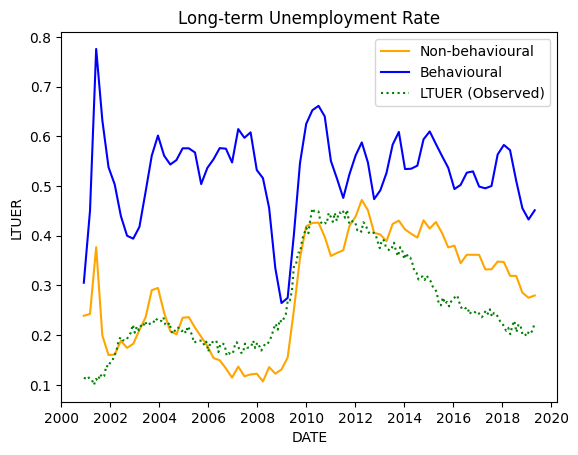

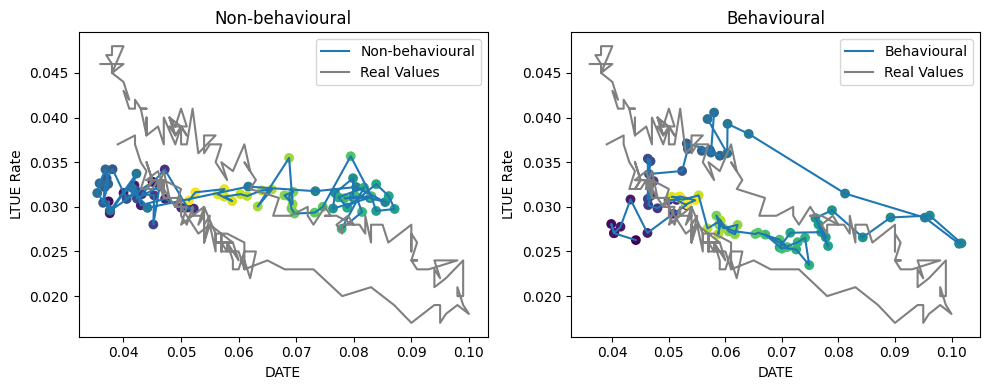

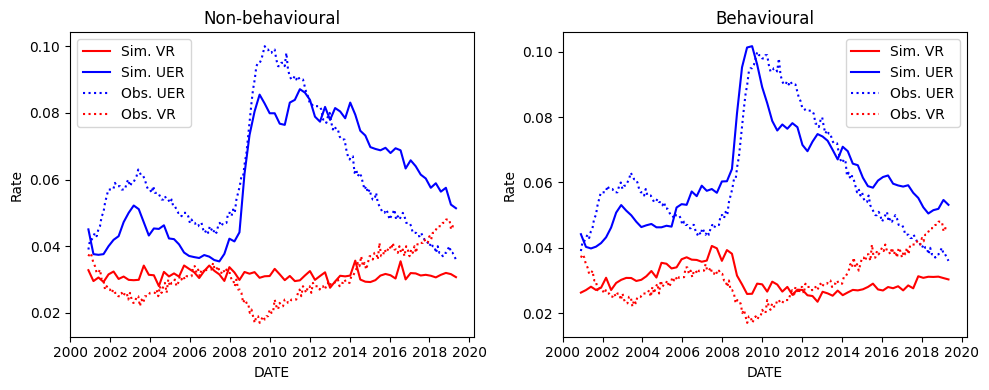

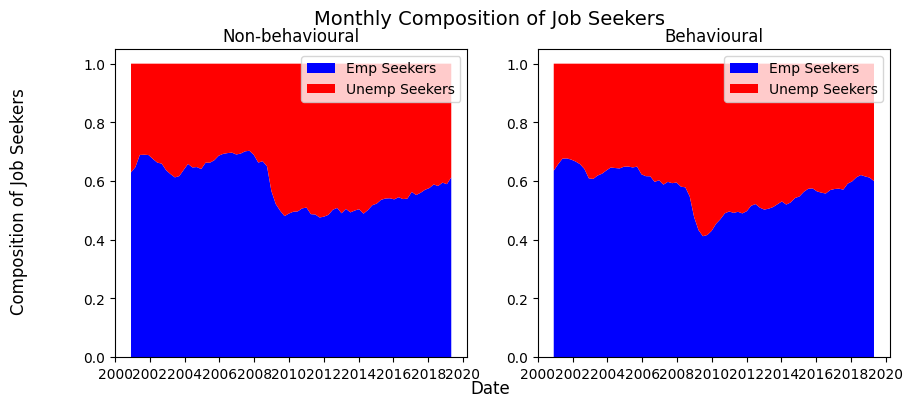

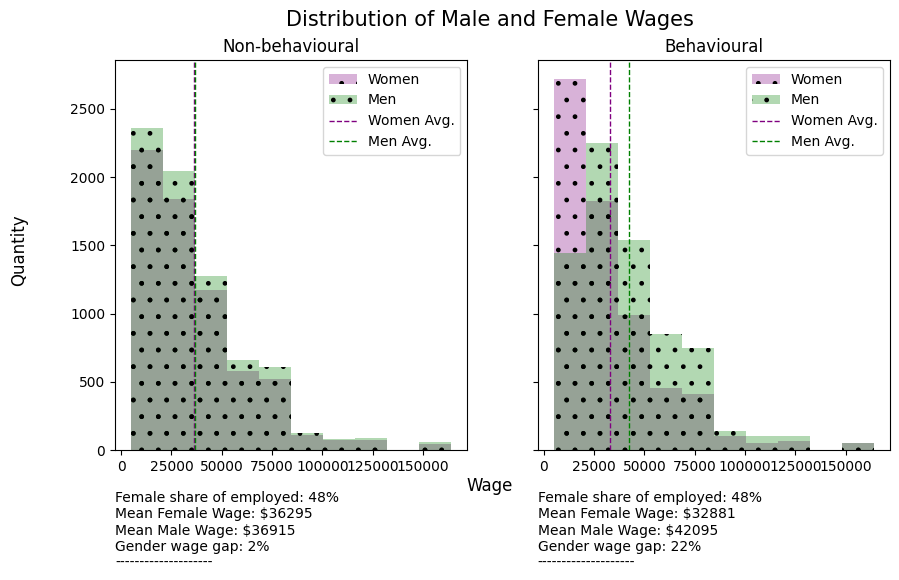

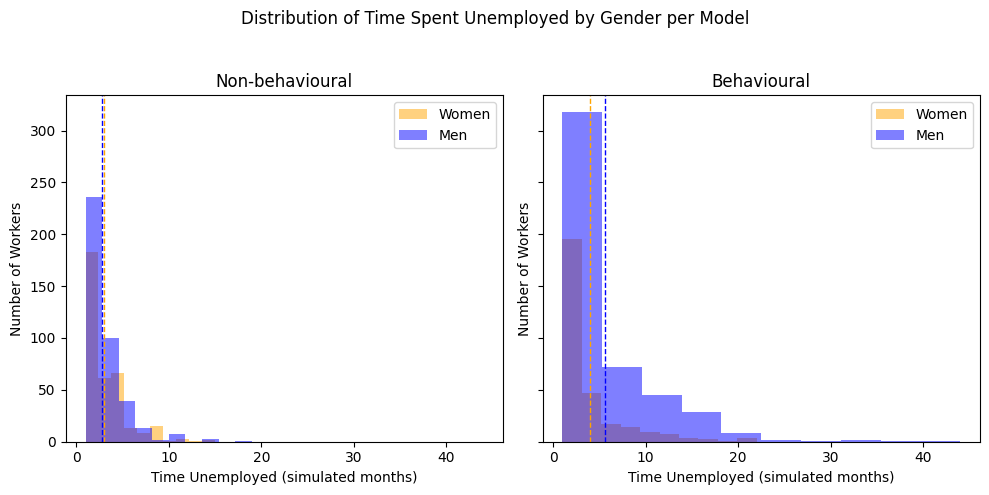

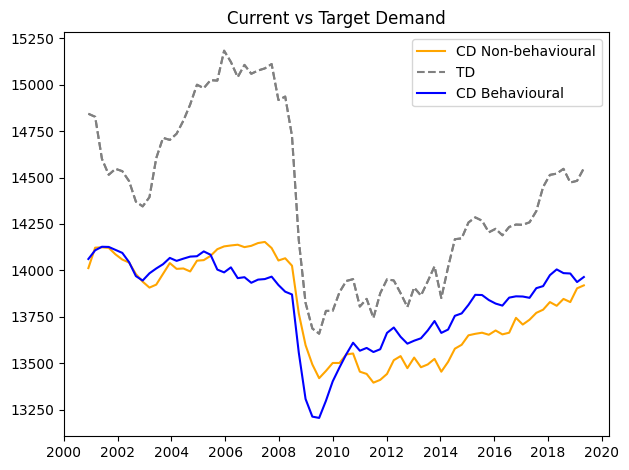

In [20]:


ue_vac_f = plot_records(sim_record_f, calib_date[0], calib_date[1])
ue_vac_t = plot_records(sim_record_t, calib_date[0], calib_date[1])

model_results = {
    "Non-behavioural": ue_vac_f,
    "Behavioural": ue_vac_t
}

net_results = {
    "Non-behavioural": sim_net_f,
    "Behavioural": sim_net_t
}


plot_ltuer(model_results, observation)
plot_bev_curve(model_results, observation)
plot_uer_vac(model_results, observation, recessions)
plot_seeker_comp(model_results, share = True)
plot_gender_gaps(net_results)
plot_ltuer_dist(net_results, gender = True, save = False)
plot_cd_vs_td(model_results)



In [21]:
# fig, ax = plt.subplots(figsize=(10, 7), sharex = True)
#     names = ['Non-behavioural', 'Behavioural']
#     colors = ['blue', 'orange']
#     for i, k in enumerate([sim_net_f, sim_net_t]):
#         w_time_unemp = []
#         m_time_unemp = []

#         for occ in k:
#             w_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if wrkr.female])
#             m_time_unemp.extend([wrkr.time_unemployed for wrkr in occ.list_of_unemployed if not(wrkr.female)])

#         women = np.array(w_time_unemp)
#         men = np.array(m_time_unemp)
#         total = np.array(w_time_unemp)
#         n_bins = 10

#         # We can set the number of bins with the *bins* keyword argument.
#         ax.hist(total, bins=n_bins, alpha = 0.5, label = names[i])
#         ax.axvline(total.mean(), linestyle='dashed', color = colors[i], linewidth=1, label = f'{names[i]} (mean)')
#         #ax.axvline(total.max(), color='grey', linestyle='dashed', linewidth=1, label = 'Max Total')
#         ax.legend(loc='upper right') 
#         ax.set_title('Non-behavioural')
#         ax.set_title('Behavioural')  
        
#         ax.legend(loc='upper right')
#         ax.set_title('Initialised State: Total')
#         #ax[0,1].set_title('Initialised State: by Gender')
#         ax.set_title('Non-behavioural: Total')
#         #ax[1,1].set_title('Non-behavioural: by Gender')
#         ax.set_title('Behavioural: Total')  
#         #ax[2,1].set_title('Behavioural: by Gender')
#         ax.set_xlabel("Time Unemployed (simulated months)")
#         ax.set_ylabel("Number of Workers")
#         #ax.set_yscale("log")

# fig.suptitle('Distribution of Time Spent Unemployed in Model') 
# if save:
#     plt.savefig(f'{path}ltuer_distributions.jpg', dpi = 300)
#     plt.close()
# else:
#     plt.show()

In [22]:
behav_params = deepcopy(final_params)
behav_params.update(
    param_df[param_df['Behav_Mode'] == True].set_index('Parameter')['Value'].to_dict()
)
behav_params.update({'behav_spec': True,
                     'search_eff_ts': search_effort_np}) 

# Run the model for behavioral case
sim_record_t_ts, sim_net_t_ts, sum_stats_t_ts = run_single_local(**behav_params)

ue_vac_t_ts = plot_records(sim_record_t_ts, calib_date[0], calib_date[1])

True
True


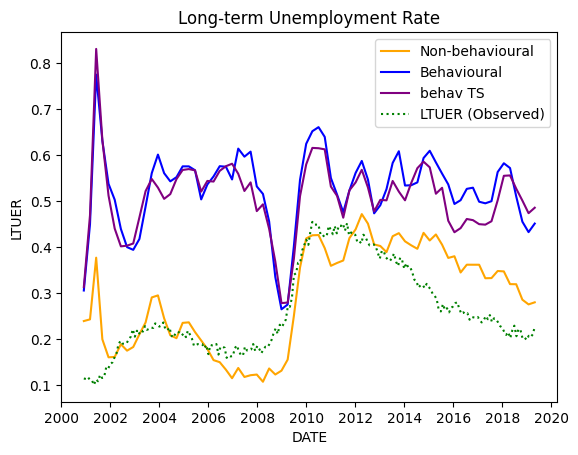

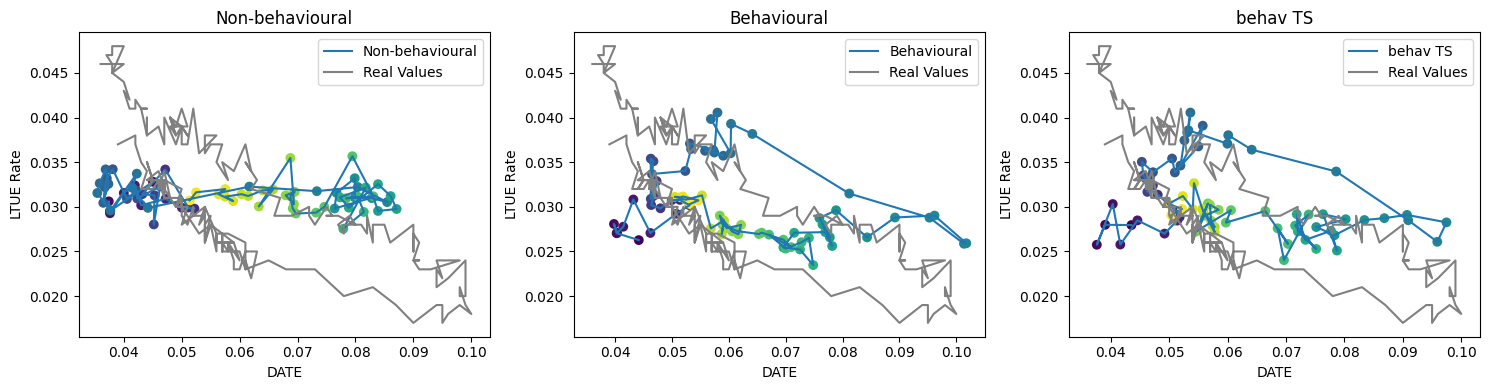

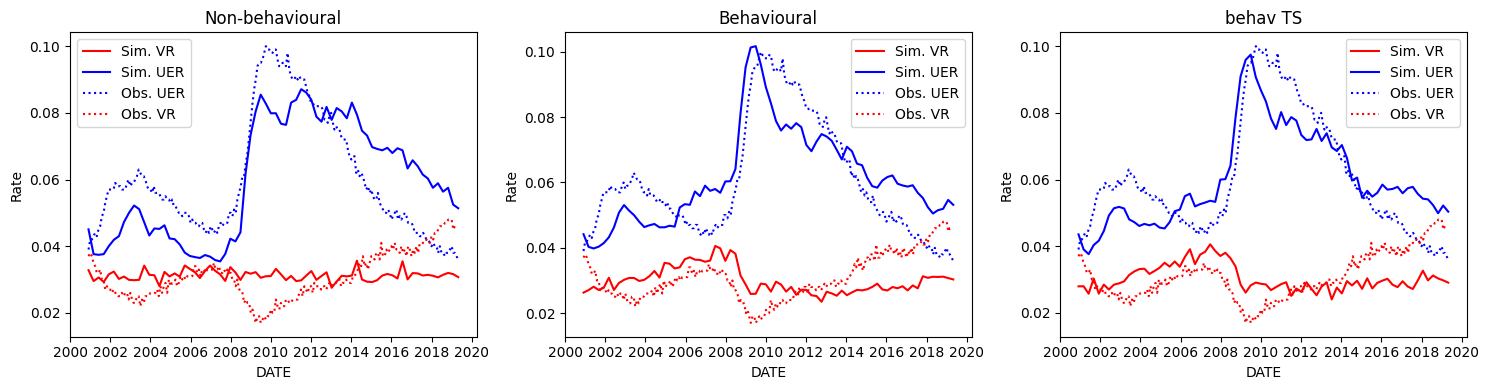

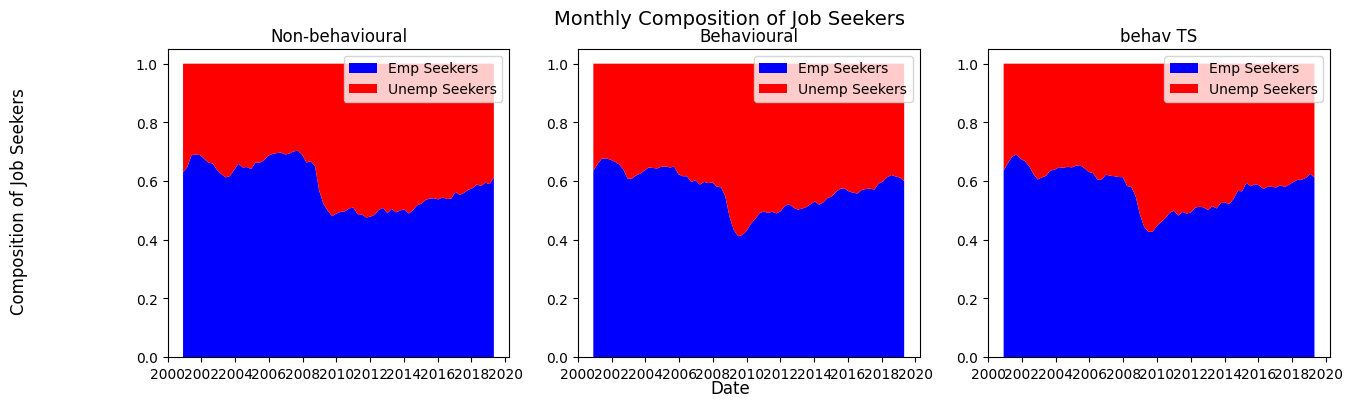

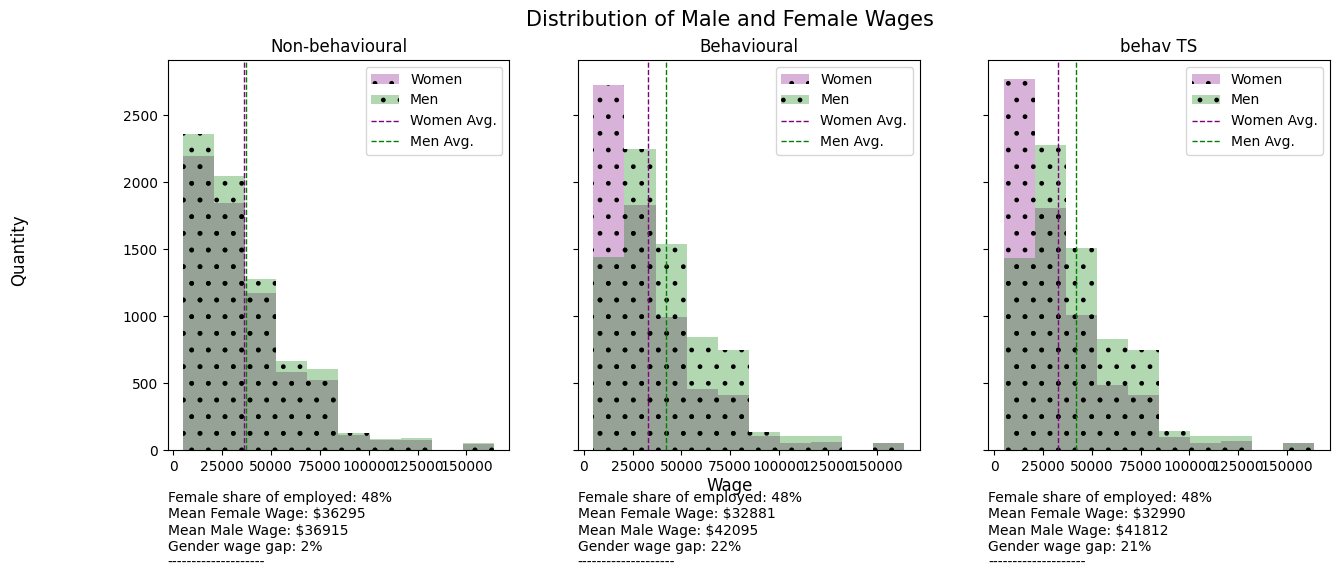

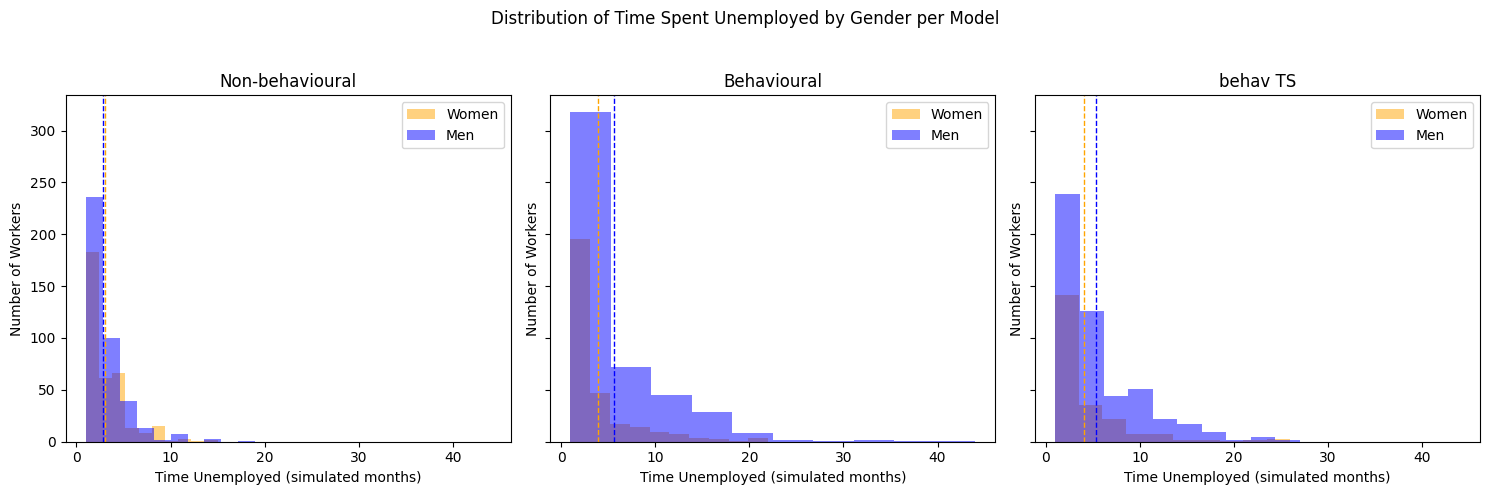

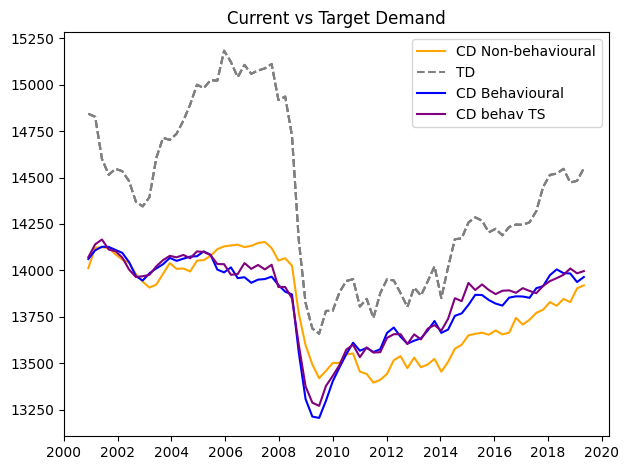

In [23]:
# # Summary values for one run 
# sim_record_t_ts = pd.DataFrame(sim_record_t_ts)
# sim_record_t_ts.columns =['Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current Demand', 'Target_Demand']

# record1_t_ts = sim_record_t_ts.groupby(['Time Step']).sum().reset_index()  

# ue_vac_t_ts = record1_t_ts.loc[:,['Workers', 'Unemployment', 'LT Unemployed Persons', 'Vacancies', 'Target_Demand']]
# ue_vac_t_ts['UE Rate'] = ue_vac_t_ts['Unemployment'] / ue_vac_t_ts['Workers']
# ue_vac_t_ts['Vac Rate'] = ue_vac_t_ts['Vacancies'] / ue_vac_t_ts['Target_Demand']
# ue_vac_t_ts['LTUE Rate'] = ue_vac_t_ts['LT Unemployed Persons'] / ue_vac_t_ts['Unemployment']
# ue_vac_t_ts['PROV DATE'] = pd.date_range(start=calib_date[0], end=calib_date[1], periods=len(sim_record_t_ts))

model_results = {
    "Non-behavioural": ue_vac_f,
    "Behavioural": ue_vac_t,
    "behav TS": ue_vac_t_ts
}

net_results = {
    "Non-behavioural": sim_net_f,
    "Behavioural": sim_net_t,
    "behav TS": sim_net_t_ts
}


####################################################
############## CURRENT VS TARGET DEMAND ############
####################################################

plot_ltuer(model_results, observation)
plot_bev_curve(model_results, observation)
plot_uer_vac(model_results, observation, recessions)
plot_seeker_comp(model_results, share = True)
plot_gender_gaps(net_results)
plot_ltuer_dist(net_results, gender = True)
plot_cd_vs_td(model_results)

# # Create a figure with a 1-row, 3-column layout
# fig, axes = plt.subplots(1,3,figsize=(17, 10))  # 3 rows, 1 column

# ### **Third Plot: Monthly US Unemployment Rate (Seasonally Adjusted)**
# macro_observations.plot.line(ax=axes[0], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
# macro_observations.plot.line(ax=axes[1], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
# macro_observations.plot.line(ax=axes[2], x='DATE', y='UER', color="blue", linestyle="dotted", label="UER (Observed)")
# macro_observations.plot.line(ax=axes[0], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
# macro_observations.plot.line(ax=axes[1], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
# macro_observations.plot.line(ax=axes[2], x='DATE', y='VACRATE', color="red", linestyle="dotted", label="VACRATE (Observed)")
# recessions.plot.area(ax=axes[1], x='DATE', color="grey", alpha=0.2)
# ue_vac_f.plot.line(ax=axes[0], x='DATE', y='UE Rate', color="skyblue", label="UER (Sim. Non-behav.)")
# ue_vac_f.plot.line(ax=axes[0], x='DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Non-behav)")
# ue_vac_t.plot.line(ax=axes[1], x='DATE', y='UE Rate', color="skyblue", label="UER (Sim. Behav.)")
# ue_vac_t.plot.line(ax=axes[1], x='DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Behav.)")
# ue_vac_t_ts.plot.line(ax=axes[2], x='DATE', y='UE Rate', color="skyblue", label="UER (Sim. Behav. w SE TS)")
# ue_vac_t_ts.plot.line(ax=axes[2], x='DATE', y='Vac Rate', color="lightcoral", label="VACRATE (Sim. Behav. w SE TS)")

# axes[0].set_xlim(calib_date[0], calib_date[1])
# axes[1].set_xlim(calib_date[0], calib_date[1])
# axes[2].set_xlim(calib_date[0], calib_date[1])
# axes[0].set_ylim(0, 0.2)
# axes[1].set_ylim(0, 0.2)
# axes[2].set_ylim(0, 0.2)
# axes[0].set_title('Monthly US Unemployment and Vacancy Rate (Seasonally Adjusted)')
# axes[0].set_xlabel('Time')
# axes[0].set_ylabel('Monthly UER & Vac Rate')
# axes[0].tick_params(axis='x', rotation=45)
# axes[0].legend()
# axes[1].set_xlabel('Time')
# axes[1].tick_params(axis='x', rotation=45)
# axes[1].legend()
# axes[2].set_xlabel('Time')
# axes[2].tick_params(axis='x', rotation=45)
# axes[2].legend()


# # Adjust layout to prevent overlap
# plt.tight_layout()

# if save:
#     plt.savefig(path + f"output_18_04/results_comp.png", dpi = 300)
#     plt.close()
# # Show the final figure with all 3 subplots
# else: 
#     plt.show()

In [24]:
# # --- Second Figure: Bottom Two Subplots ---
# fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# # Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
# #axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Employment'], label="Emp Non-behavioural")
# axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Unemployment'], label="Unemp Non-behavioural")
# axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Vacancies'], label="Vacs Non-behavioural")
# axes2[0].set_title("Non-behavioural")
# # axes2[0].set_ylim(0.015, 0.055)
# # axes2[0].set_xlim(0.03, 0.125)
# axes2[0].legend()

# # Fourth Plot (Bottom-Right: Behavioural Beveridge Curve)
# # Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
# #axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Employment'], label="Emp Behavioural")
# axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Unemployment'], label="Unemp Behavioural")
# axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Vacancies'], label="Vacs Behavioural")
# axes2[1].set_title("Behavioural")
# # axes2[1].set_ylim(0.015, 0.055)
# # axes2[1].set_xlim(0.03, 0.125)
# axes2[1].legend()

# plt.tight_layout()
# # Save the figure to the output folder
# if save:
#     plt.savefig(f"bev_curves.png", dpi=300)
#     plt.close()  # Close figure to free memory
# else:
#     plt.show()

# # --- Second Figure: Bottom Two Subplots ---
# fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# # Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
# #axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Employment'], label="Emp Non-behavioural")
# axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Current Demand'], label="CD Non-behavioural")
# axes2[0].plot(ue_vac_f['PROV DATE'], ue_vac_f['Target_Demand'], label="TD Non-behavioural")
# axes2[0].set_title("Non-behavioural")
# # axes2[0].set_ylim(0.015, 0.055)
# # axes2[0].set_xlim(0.03, 0.125)
# axes2[0].legend()

# # Fourth Plot (Bottom-Right: Behavioural Beveridge Curve)
# # Third Plot (Bottom-Left: Non-behavioural Beveridge Curve)
# #axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Employment'], label="Emp Behavioural")
# axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Current Demand'], label="CD Behavioural")
# axes2[1].plot(ue_vac_t['PROV DATE'], ue_vac_t['Target_Demand'], label="TD Behavioural")
# axes2[1].set_title("Behavioural")
# # axes2[1].set_ylim(0.015, 0.055)
# # axes2[1].set_xlim(0.03, 0.125)
# axes2[1].legend()

# plt.tight_layout()
# # Save the figure to the output folder
# if save:
#     plt.savefig(path + f"output_18_04/bev_curves.png", dpi=300)
#     plt.close()  # Close figure to free memory
# else:
#     plt.show()